### Make segformer input images JPGs

In [2]:
import os
from PIL import Image

def convert_tif_to_png(input_dir, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.lower().endswith('.tif') or filename.lower().endswith('.tiff'):
            # Open the TIF image
            tif_path = os.path.join(input_dir, filename)
            with Image.open(tif_path) as img:
                # Create the output PNG filename
                png_filename = os.path.splitext(filename)[0] + '.png'
                png_path = os.path.join(output_dir, png_filename)
                
                # Convert and save as PNG without converting to RGB
                img.save(png_path, 'PNG')
                # print(f"Converted {filename} to {png_filename}")

# Example usage:
input_directory = '/Users/nadja/Documents/1. Project/Thesis/Verified_GT/groundtruth_mask'
output_directory = '/Users/nadja/Documents/1. Project/Thesis/Verified_GT/png_GT'
convert_tif_to_png(input_directory, output_directory)


### Test set performance of model

In [ ]:
import torch
from torch import nn
from torchmetrics.functional import jaccard_index
from torchmetrics.functional.classification import multiclass_accuracy
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation

from transformers import SegformerImageProcessor
import pandas as pd 
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
import wandb

# adapted from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegformerImageProcessor): image processor to prepare images + segmentation maps.
        """
        self.root_dir = root_dir
        self.image_processor = SegformerImageProcessor(
            image_mean = [74.90, 85.26, 80.06], # use mean calculated over our dataset
            image_std = [15.05, 13.88, 12.01], # use std calculated over our dataset
            do_reduce_labels=False
            )

        self.img_dir = os.path.join(self.root_dir, "jpg_rgb")
        self.ann_dir = os.path.join(self.root_dir, "png_GT")
        
        # Get all image filenames without extension
        dataframe = pd.read_csv(
            f"{root_dir}/new_palsa_labels.csv", 
            names=['filename', 'palsa', 'matthias', 'difference'], 
            header=0
            )
        
        dataframe = dataframe.loc[dataframe['palsa']>0]
        checked_names = list(dataframe['filename'])
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(self.img_dir) if f[:-4] in checked_names]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        ann_path = os.path.join(self.ann_dir, f"{img_name}.png")

        image = Image.open(img_path)
        segmentation_map = Image.open(ann_path)

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import wandb
import rasterio

# model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
model_name = "sawthiha/segformer-b0-finetuned-deprem-satellite"

# Initialize wandb API
api = wandb.Api()

# Specify the artifact path
artifact_name = 'finetuned_segformer:v93'
artifact_path = f'nadjaflechner/Finetune_segformer_sweep/{artifact_name}'

# Download the artifact
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

# Load the model
device = torch.device("cpu")
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# Load the state dict
state_dict = torch.load(f"{artifact_dir}/best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

# Define Dataset
data_directory = "/Users/nadja/Documents/1. Project/Thesis/Verified_GT"
full_dataset = SemanticSegmentationDataset(data_directory)
test_loader = DataLoader(full_dataset, batch_size=8)

run = wandb.init(
    project="Finetune_segformer_sweep"
    config={
        "model": model_name,
        "artifact": artifact_name
        },
    tags=["Testing"]
)

# Initialize metrics 
bg_jaccard_scores = []
target_jaccard_scores = []
overall_accuracy = []

with torch.no_grad():
    for batch in test_loader:
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        logits = outputs.logits
        upsampled_logits = F.interpolate(
            logits.unsqueeze(1).float(), 
            size=[logits.shape[1],labels.shape[-2],labels.shape[-1]], 
            mode="nearest")

        # Convert logits to binary segmentation mask
        predicted = torch.argmax(logits, dim=1)  # Shape: (batch_size, 128, 128)
        
        # Upsample the predicted mask to match the label size
        upsampled_predicted = F.interpolate(
            predicted.unsqueeze(1).float(), 
            size=labels.shape[-2:], 
            mode="nearest"
        )

        # Calculate Jaccard score (IoU) for both classes
        jaccard = jaccard_index(
            upsampled_predicted.squeeze(1).long(), 
            labels, 
            task="multiclass", 
            num_classes=2, 
            average='none'
        )
        bg_jaccard_scores.append(jaccard[0])
        target_jaccard_scores.append(jaccard[1])

        # Overall accuracy
        accuracy = multiclass_accuracy(
            upsampled_predicted.squeeze(1).long(), 
            labels, 
            num_classes=2, 
            average='micro'
        )
        overall_accuracy.append(accuracy)

avg_bg_jaccard = sum(bg_jaccard_scores) / len(bg_jaccard_scores)
avg_target_jaccard = sum(target_jaccard_scores) / len(target_jaccard_scores)
avg_overall_accuracy = sum(overall_accuracy) / len(overall_accuracy)
wandb.log({"background_jaccard": avg_bg_jaccard})
wandb.log({"target_jaccard": avg_target_jaccard})
wandb.log({"avg_overall_accuracy": avg_overall_accuracy})

### Visualize output

In [ ]:

def plot_segmentation(filename):
    # Load and process the image
    image = Image.open(f"/home/nadjaflechner/Palsa_data/generated_datasets/Verified_GTs/jpg/{filename}.jpg")
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    # Process the output
    logits = outputs.logits.cpu()
    predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
    # Create color segmentation
    color_seg = np.zeros((predicted_segmentation_map.shape[0],
                        predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

    color = np.array([4, 250, 7])
    color_seg[predicted_segmentation_map == 1, :] = color  # Changed from 0 to 1
    # Convert to BGR
    color_seg = color_seg[..., ::-1]

    # Overlay segmentation on image
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    # Input image
    ax1.imshow(image)
    ax1.set_title("Input Image")
    ax1.axis('off')

    # Segmentation prediction
    ax2.imshow(img)
    ax2.set_title("Segmentation Prediction")
    ax2.axis('off')

    # Ground truth
    GT = rasterio.open(f"/home/nadjaflechner/Palsa_data/generated_datasets/Verified_GTs/groundtruth_mask/{filename}.tif").read()
    GT = np.squeeze(GT)  # Remove single-dimensional entries
    GT = np.array(Image.fromarray(GT).resize((400, 400), Image.NEAREST))  # Upsample to 400x400
    GT_overlay = np.array(image) * 0.5 + np.expand_dims(GT, axis=2) * np.array([4, 250, 7]) * 0.5
    GT_overlay = GT_overlay.astype(np.uint8)
    ax3.imshow(GT_overlay)
    ax3.set_title("Ground Truth")
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
filenames = ['753_67_2550_2014_crop_51','753_67_2550_2014_crop_61','753_67_2550_2014_crop_62', '760_74_5025_2018_crop_48']
plot_segmentation(filenames[1])

### OTHER

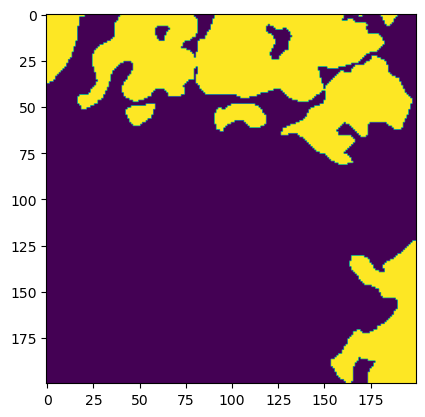

In [20]:
import matplotlib.pyplot as plt
import numpy as np

gt = Image.open("/Users/nadja/Documents/1. Project/Thesis/Verified_GT/png_GT/753_67_2550_2014_crop_62.png")
img_array = np.array(gt)
np.unique(img_array, return_counts=True)
# gt.show()
plt.imshow(img_array)


IndentationError: unexpected indent (2629510161.py, line 7)